In [5]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from scipy.optimize import curve_fit

In [9]:
nObj = 0

class File:
    def __init__(self,infile):
        if (isinstance(infile,ROOT.TFile)):
            self.TFile = infile
        else:
            self.TFile = ROOT.TFile(infile)

    def get(self,name,**kwargs):
        if (not self.TFile.GetListOfKeys().Contains(name)):
            raise ValueError("File does not contain specified object")
        h = self.TFile.Get(name)
        if (isinstance(h,ROOT.TH2)):
            return Hist2D(h,**kwargs)
        elif (isinstance(h,ROOT.TH1)):
            return Hist1D(h,**kwargs)
        else:
            raise ValueError("Object is not a supported type")

    def getNames(self):
        return [i.GetName() for i in self.TFile.GetListOfKeys()]

    def plotPoints(self,name,rebin=1,scale=1,**kwargs):
        h = self.get(name,rebin=rebin,scale=scale)
        if (isinstance(h,Hist1D)):
            return h.plotPoints(**kwargs)
        else:
            raise ValueError("This is not a 1D histogram and cannot be plotted with this method")
        
    def plotBand(self,name,rebin=1,scale=1,**kwargs):
        h = self.get(name,rebin=rebin,scale=scale)
        if (isinstance(h,Hist1D)):
            return h.plotBand(**kwargs)
        else:
            raise ValueError("This is not a 1D histogram and cannot be plotted with this method")
        
    def plotBar(self,name,rebin=1,scale=1,**kwargs):
        h = self.get(name,rebin=rebin,scale=scale)
        if (isinstance(h,Hist1D)):
            return h.plotBar(**kwargs)
        else:
            raise ValueError("This is not a 1D histogram and cannot be plotted with this method")
        
    def plotHeatmap(self,name,rebinx=1,rebiny=1,**kwargs):
        h = self.get(name,rebinx=rebinx,rebiny=rebiny)
        if (isinstance(h,Hist2D)):
            return h.plotHeatmap(**kwargs)
        else:
            raise ValueError("This is not a 2D histogram and cannot be plotted with this method")
        
class Hist1D:
    def __init__(self,hist,rebin=1,scale=1):
        global nObj
        self.TH1 = hist.Clone(str(nObj))
        nObj = nObj + 1
        
        if (rebin != 1):
            self.TH1.Rebin(rebin)
            
        g = ROOT.TGraphAsymmErrors(self.TH1)
        self.x = np.array(g.GetX())
        self.y = np.array(g.GetY())*scale
        xerr = []
        yerr = []
        for i in range(g.GetN()):
            xerr.append(g.GetErrorX(i))
            yerr.append(g.GetErrorY(i))
        self.xerr = np.array(xerr)
        self.yerr = np.array(yerr)*scale

    def scale(self,factor):
        self.y *= factor
        self.yerr *= factor

    def rebin(self,factor):
        if (factor != 1):
            self.TH1.Rebin(factor)
            g = ROOT.TGraphAsymmErrors(self.TH1)
            self.x = np.array(g.GetX())
            self.y = np.array(g.GetY())
            xerr = []
            yerr = []
            for i in range(g.GetN()):
                xerr.append(g.GetErrorX(i))
                yerr.append(g.GetErrorY(i))
            self.xerr = np.array(xerr)
            self.yerr = np.array(yerr)

    def areaNorm(self,reference):
        factor = np.sum(reference.y)/np.sum(self.y)
        self.scale(factor)
        return factor
        
    def plotPoints(self,**kwargs):
        return plt.errorbar(self.x,self.y,yerr=self.yerr,**kwargs)

    def plotBand(self,alpha=0.25,**kwargs):
        line = plt.plot(self.x,self.y,**kwargs)[0]
        band = plt.fill_between(self.x,self.y-self.yerr,self.y+self.yerr,
                                color=line.get_color(),zorder=line.zorder,
                                alpha=alpha)
        return line, band

    def plotBar(self,shift=0,**kwargs):
        bar = plt.bar(self.x+shift, self.y, **kwargs)
        
        return bar

class Hist2D:
    def __init__(self,hist,rebinx=1,rebiny=1):
        global nObj
        self.TH2 = hist.Clone(str(nObj))
        nObj = nObj + 1
        
        if (rebinx != 1):
            self.TH2.RebinX(rebinx)
        if (rebiny != 1):
            self.TH2.RebinY(rebiny)

        NX = self.TH2.GetNbinsX()
        NY = self.TH2.GetNbinsY()
    
        xedge = []
        yedge = []
        z = []
        zerr = []
        
        for j in range(NX):
            xedge.append(self.TH2.GetXaxis().GetBinLowEdge(j+1))
        xedge.append(self.TH2.GetXaxis().GetBinUpEdge(NX))
    
        for i in range(NY):
            yedge.append(self.TH2.GetYaxis().GetBinLowEdge(i+1))
            zcol = []
            zerrcol = []
            for j in range(NX):
                zval = self.TH2.GetBinContent(j+1,i+1)
                zcol.append(zval)
                zerrcol.append(self.TH2.GetBinError(j+1,i+1))
            z.append(zcol)
            zerr.append(zerrcol)
        yedge.append(self.TH2.GetYaxis().GetBinUpEdge(NY))
            
        self.xedge = np.array(xedge)
        self.yedge = np.array(yedge)
        self.z = np.array(z)
        self.zerr = np.array(zerr)
    
    def plotHeatmap(self,kill_zeros=True,**kwargs):
        z = self.z
        if (kill_zeros):
            z[z==0] = np.nan
        return plt.pcolormesh(self.xedge,self.yedge,self.z,**kwargs)

    def projectionX(self,**kwargs):
        return Hist1D(self.TH2.ProjectionX(),**kwargs)

    def projectionY(self,**kwargs):
        return Hist1D(self.TH2.ProjectionY(),**kwargs)

In [3]:
#Constant and function definitions
mass_neutron = 0.93956542052
mass_proton  = 0.93827208816
mass_piminus = 0.13957039
mass_photon  = 0

def create_yield_hist(bins_i, bins_j):
    yield_hist = []
    for i in range(bins_i):
        new_row = []
        for j in range(bins_j):
            new_hist = root.TH1F("", "", 100, 0.5, 1.5)
            new_row.append(new_hist)
        yield_hist.append(new_row)
    
    return yield_hist

def hist_points(hist):
    NBins = hist.GetNbinsX()
    x, y, x_err, y_err = np.empty(NBins), np.empty(NBins), np.empty(NBins), np.empty(NBins)
    for i in range(NBins):
        x[i], y[i], x_err[i], y_err[i]  = hist.GetBinCenter(i), hist.GetBinContent(i), hist.GetBinWidth(i), hist.GetBinError(i)
    return [x, y, x_err, y_err]

def SqrtS_to_Eg(SqrtS):
    return (SqrtS**2-mass_neutron**2)/(2*mass_neutron)

def Eg_to_SqrtS(Eg):
    return np.sqrt(mass_neutron**2+2*mass_neutron*Eg)

def abst_max(s):
    return abs(mass_photon**2+mass_neutron**2+mass_piminus**2+mass_proton**2-s)

def piminus_to_piplus_ratio(s,t):
    u = mass_photon**2+mass_neutron**2+mass_piminus**2+mass_proton**2 - s - t
    e_d = -1/3
    e_u = 2/3
    return ((e_d*u+e_u*s)/(e_u*u+e_d*s))**2

def fitting_function(x, mu, c1, sigma1, c2, sigma2):
    return c1*np.exp(-(x-mu)**2/(2*sigma1**2))+c2*np.exp(-(x-mu)**2/(2*sigma2**2))

In [32]:
edges_eg    = np.array([6.0, 7.0, 8.0, 9.0, 10.0, 11.0])
edges_abst  = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 15.0])
edges_theta = np.array([0.0, 10.0, 15.0, 20.0, 40.0, 60.0])
points_eg,    widths_eg    = np.empty(edges_eg.size-1),    np.empty(edges_eg.size-1)
points_abst,  widths_abst  = np.empty(edges_abst.size-1),  np.empty(edges_abst.size-1)
points_theta, widths_theta = np.empty(edges_theta.size-1), np.empty(edges_theta.size-1)

for i in range(edges_eg.size-1):
    points_eg[i]    = (edges_eg[i+1]+edges_eg[i])/2
    widths_eg[i]    = (edges_eg[i+1]-edges_eg[i])/2
for i in range(edges_abst.size-1):
    points_abst[i]  = (edges_abst[i+1]+edges_abst[i])/2
    widths_abst[i]  = (edges_abst[i+1]-edges_abst[i])/2
for i in range(edges_theta.size-1):
    points_theta[i] = (edges_theta[i+1]+edges_theta[i])/2
    widths_theta[i] = (edges_theta[i+1]-edges_theta[i])/2

In [20]:
file_phi = File("/volatile/halld/home/boyu/src_analysis/analysis/phi.root")
file_rho = File("/volatile/halld/home/boyu/src_analysis/analysis/rho.root")

## Acceptance

Text(0.5, 1.0, 'Compare $\\phi$ and $\\rho$ simulation (scaled approximately to data)')

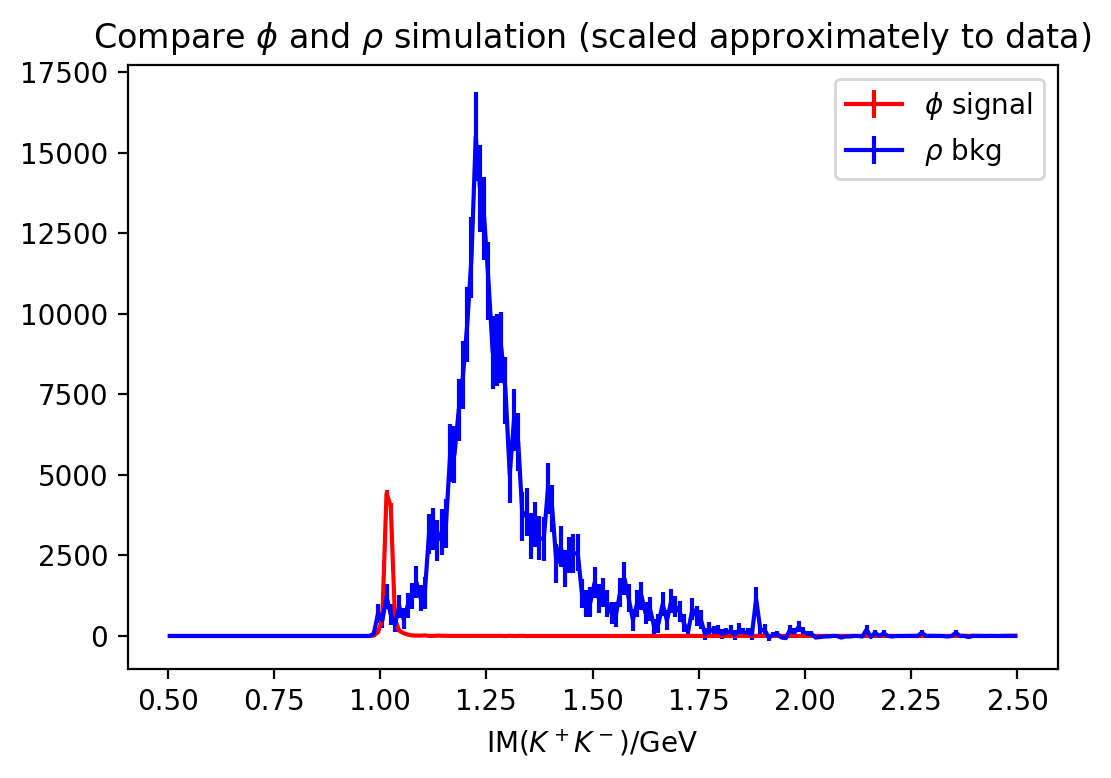

In [62]:
plt.rcParams['figure.dpi'] = 200
hist_phi = file_phi.get("InvariantMass_KinFit_After")
hist_rho = file_rho.get("InvariantMass_KinFit_After")
hist_rho.scale(100)
hist_phi.scale(2)
hist_phi.plotPoints(label='$\phi$ signal', c='r')
#hist_rho.plotPoints(label='$\\rho$ bkg', c='b')
plt.errorbar(hist_phi.x, hist_phi.y+hist_rho.y, yerr=hist_phi.yerr+hist_rho.yerr,label='$\phi + \\rho$', c='g')
plt.legend()
plt.xlabel('IM($K^+K^-$)/GeV')
plt.title('Compare $\phi$ and $\\rho$ simulation (scaled approximately to data)')

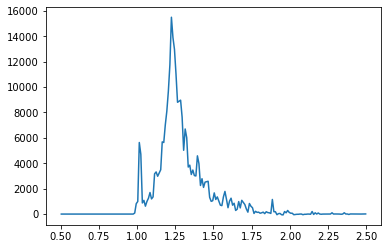

In [28]:
plt.plot(hist_phi.x, hist_phi.y+hist_rho.y)